Reference - this code is just modification of https://github.com/dennybritz/reinforcement-learning, https://gist.github.com/kkweon/c8d1caabaf7b43317bc8825c226045d2

In [1]:
%run ../utils/commonImports.py
%run ../utils/tradingImports.py
%matplotlib inline

In [2]:
import gym
import itertools
import matplotlib
import sys
import tensorflow as tf
import collections

matplotlib.style.use('ggplot')

In [3]:
from collections import namedtuple
from matplotlib import pyplot as plt

def plot_episode_stats(stats, smoothing_window=10, noshow=False):
    # Plot the episode reward over time
    fig = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if noshow:
        plt.close(fig)
    else:
        plt.show(fig)

    return fig

# Load Data

In [4]:
dataRoot = 'D:\\Dropbox\\My work\\krypl-project\\dataFeatures\\poloniex\\5min'
fileName = 'USDT_BTC_5min_2016-01-01_2017-12-31.tsv'
file = '{dataRoot}\\{fileName}'.format(dataRoot=dataRoot, fileName=fileName)

usdtBtc = pd.read_csv(file, sep='\t').query("date >= '2017-01-01'")\
    .sort_values('date').reset_index().drop('index', axis=1)
usdtBtc = usdtBtc

trainRatio = 0.7
trainSize = int(usdtBtc.shape[0] * trainRatio)
usdtBtcTrain = usdtBtc.iloc[:trainSize]
usdtBtcTest = usdtBtc.iloc[trainSize:].reset_index().drop('index', axis=1)

usdtBtcManagerTrain = CurrencyDataManager(usdtBtcTrain['close'], usdtBtcTrain)
usdtBtcManagerTest = CurrencyDataManager(usdtBtcTest['close'], usdtBtcTest)
wallet = {'usdt': 1000}
contractPair = ContractPair.new('usdt', 'btc')

In [5]:
dataManager = deepcopy(usdtBtcManagerTrain)
exchange = BackTestExchange(dataManager, deepcopy(wallet), 0.0025)

# Dummy Estimators

Just to test learning performance

In [6]:
class DummyPolicyEstimator:
    def predict(self, state):
        return [0.7, 0.1, 0.2] 
    
    def update(self, state, target, action):
        pass

    
class DummyValueEstimator:
    def predict(self, state):
        return 0
    
    def update(self, state, target):
        pass

# Keras perceptron

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam    

from keras import layers
from keras.models import Model
from keras import backend as K
from keras import utils as np_utils
from keras import optimizers
from keras import losses
from modeling.rl.estimator import PolicyEstimator, ValueEstimator, MLPPolicyEstimator


class MLPValueEstimator(ValueEstimator):

    def __init__(self, input_dim, hidden_dims=[32, 32]):
        self.input_dim = input_dim
        with tf.variable_scope("value_estimator"):
            self.__build_network(input_dim, hidden_dims)
            self.__build_train_fn()

    def __build_network(self, input_dim, hidden_dims=[32, 32]):        
        self.X = layers.Input(shape=(input_dim,))
        net = self.X

        for h_dim in hidden_dims:
            net = layers.Dense(h_dim)(net)
            net = layers.Activation("relu")(net)

        net = layers.Dense(1)(net)
        self.model = Model(inputs=self.X, outputs=net)

    def __build_train_fn(self):
        target_placeholder = K.placeholder(shape=(None,), name="target")

        adam = optimizers.Adam()
        loss = losses.mean_squared_error(target_placeholder, self.model.output)
        updates = adam.get_updates(params=self.model.trainable_weights, loss=loss)

        self.train_fn = K.function(inputs=[self.model.input, target_placeholder],
                                   outputs=[],
                                   updates=updates)

    def predict(self, state):
        action_prob = self.model.predict(state)
        return action_prob[0]

    def update(self, S, R):
        discount_reward = np.array([R])
        self.train_fn([S, discount_reward])

Using TensorFlow backend.


# Reinforce

In [8]:
usdtBtcTrain.columns

Index(['date', 'close', 'return', 'return_1', 'return_2', 'zscore_36_return',
       'zscore_288_return', 'pma36', 'ma_12_108', 'ma_36_288', 'ac36', 'ac288',
       'zscore_36_volume', 'zscore_288_volume', 'zscore_2016_volume', 'vol36',
       'vol288', 'vol2016', 'dv_36_288'],
      dtype='object')

In [9]:
from modeling.rl.enviroment import ExchangeEnv
from modeling.rl.estimator import PerceptronValueEstimator

# cols = ['close', 'return', 'return_1', 'return_2', 'zscore_36_return', 'zscore_288_return']

env = ExchangeEnv(
    data=usdtBtcTrain.drop('date', axis=1),
    price_col='close',
    pair=contractPair,
    wallet=wallet,
    fee=0.0025,
    epoch_len=288,
    trade_amount=100
)

In [19]:
%%time
from modeling.rl.reinforce import reinforce
from keras import backend as K

# tf.reset_default_graph()
K.clear_session()

global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = MLPPolicyEstimator(env.observation_space.n, env.action_space.n, [env.observation_space.n])
# policy_estimator = DummyPolicyEstimator()
# value_estimator = MLPValueEstimator(env.observation_space.n, [env.observation_space.n])
value_estimator = DummyValueEstimator()

stats, episodes = reinforce(env, policy_estimator, value_estimator, 1000, discount_factor=1.0)

Step 286 @ Episode 1000/1000 (0.0)Wall time: 7min 15s


D:\Git projekty\krypl-project\modeling\rl\utils.py:5: RuntimeWarning: invalid value encountered in less
  return np.random.choice(np.arange(len(arr)), p=arr)


In [20]:
episode_stats = pd.DataFrame(episodes[-1])
for k in episode_stats['debug'].values[0].keys():
    episode_stats[k] = episode_stats['debug'].apply(lambda x: x[k])

In [21]:
episode_stats.query('action < 2')

,state,action,reward,next_state,done,debug,open,err,initial_value,current_value
0,"[[-9.86582774255007e-05, 0.0031918842162563803...",0,0.0000,"[[0.0004933399260063087, -9.86582774255007e-05...",False,"{'open': False, 'err': False, 'initial_value':...",False,False,"1,000.0000","1,000.0000"
1,"[[0.0004933399260063087, -9.86582774255007e-05...",0,0.0000,"[[0.0008370874950689443, 0.0004933399260063087...",False,"{'open': False, 'err': False, 'initial_value':...",False,False,"1,000.0000","1,000.0000"
2,"[[0.0008370874950689443, 0.0004933399260063087...",0,0.0000,"[[0.002612402194735575, 0.0008370874950689443,...",False,"{'open': False, 'err': False, 'initial_value':...",False,False,"1,000.0000","1,000.0000"
3,"[[0.002612402194735575, 0.0008370874950689443,...",0,0.0000,"[[0.0009828010074000026, 0.002612402194735575,...",False,"{'open': False, 'err': False, 'initial_value':...",False,False,"1,000.0000","1,000.0000"
4,"[[0.0009828010074000026, 0.002612402194735575,...",0,0.0000,"[[-0.0034364261070370943, 0.000982801007400002...",False,"{'open': False, 'err': False, 'initial_value':...",False,False,"1,000.0000","1,000.0000"
5,"[[-0.0034364261070370943, 0.000982801007400002...",0,0.0000,"[[0.00098522217733521, -0.0034364261070370943,...",False,"{'open': False, 'err': False, 'initial_value':...",False,False,"1,000.0000","1,000.0000"
6,"[[0.00098522217733521, -0.0034364261070370943,...",0,0.0000,"[[0.0034443892305375807, 0.00098522217733521, ...",False,"{'open': False, 'err': False, 'initial_value':...",False,False,"1,000.0000","1,000.0000"
7,"[[0.0034443892305375807, 0.00098522217733521, ...",0,0.0000,"[[-0.0021503646299521058, 0.003444389230537580...",False,"{'open': False, 'err': False, 'initial_value':...",False,False,"1,000.0000","1,000.0000"
8,"[[-0.0021503646299521058, 0.003444389230537580...",0,0.0000,"[[0.002646983795643543, -0.0021503646299521058...",False,"{'open': False, 'err': False, 'initial_value':...",False,False,"1,000.0000","1,000.0000"
9,"[[0.002646983795643543, -0.0021503646299521058...",0,0.0000,"[[-0.002670330259817111, 0.002646983795643543,...",False,"{'open': False, 'err': False, 'initial_value':...",False,False,"1,000.0000","1,000.0000"


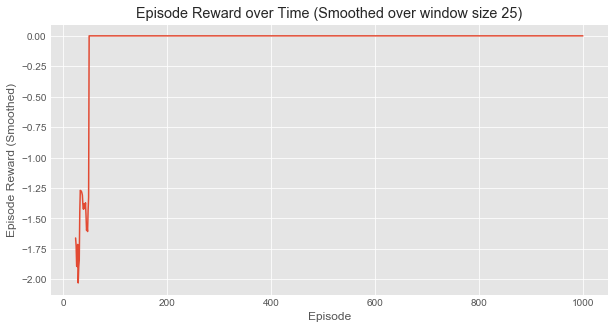

In [22]:
plot_episode_stats(stats, smoothing_window=25);